# Calculate phenotypic activity

A common first analysis for morphological datasets is the activity of
the cells’ phenotypes. We will use the
[copairs](https://github.com/cytomining/copairs) package, which makes
use of [mean average
precision](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11014546/) to
obtain a metric of replicability for any set of morphological profiles.
In other words, it indicates how similar a given set of compounds are,
relative to their negative controls, which is usually cells that have
experienced no perturbation.

In [1]:
import polars as pl
import polars.selectors as cs
import requests
import seaborn as sns
from broad_babel.query import get_mapper
from copairs.map import average_precision

We will be using the CRISPR dataset specificed in our kson index, but we
will select a subset of perturbations and the controls present.

In [2]:
INDEX_FILE = "https://raw.githubusercontent.com/jump-cellpainting/datasets/v0.11.0/manifests/profile_index.json"
response = requests.get(INDEX_FILE)
profile_index = response.json()

CRISPR_URL = (
    pl.DataFrame(profile_index).filter(pl.col("subset") == "crispr").item(0, "url")
)
profiles = pl.scan_parquet(CRISPR_URL)

Sample perturbations and add known negative control.

In [3]:
jcp_ids = (
    profiles.select(pl.col("Metadata_JCP2022")).unique().collect().to_series().sort()
)
subsample = jcp_ids.sample(10, seed=42)
subsample = (*subsample, "JCP2022_800002")  # Add the only control in CRISPR data
profiles_subset = profiles.filter(pl.col("Metadata_JCP2022").is_in(subsample)).collect()
unique_plates = profiles_subset.filter(pl.col("Metadata_JCP2022") != subsample[-1])[
    "Metadata_Plate"
].unique()
perts_controls = profiles_subset.filter(pl.col("Metadata_Plate").is_in(unique_plates))
with pl.Config() as cfg:
    cfg.set_tbl_cols(7)  # Limit the number of columns printed
    print(perts_controls.head())

shape: (5, 263)
┌──────────────┬──────────────┬──────────────┬─────────────┬───┬───────────┬───────────┬───────────┐
│ Metadata_Sou ┆ Metadata_Pla ┆ Metadata_Wel ┆ Metadata_JC ┆ … ┆ X_257     ┆ X_258     ┆ X_259     │
│ rce          ┆ te           ┆ l            ┆ P2022       ┆   ┆ ---       ┆ ---       ┆ ---       │
│ ---          ┆ ---          ┆ ---          ┆ ---         ┆   ┆ f32       ┆ f32       ┆ f32       │
│ str          ┆ str          ┆ str          ┆ str         ┆   ┆           ┆           ┆           │
╞══════════════╪══════════════╪══════════════╪═════════════╪═══╪═══════════╪═══════════╪═══════════╡
│ source_13    ┆ CP-CC9-R1-05 ┆ I23          ┆ JCP2022_800 ┆ … ┆ -0.024703 ┆ 0.148245  ┆ 0.069796  │
│              ┆              ┆              ┆ 002         ┆   ┆           ┆           ┆           │
│ source_13    ┆ CP-CC9-R1-05 ┆ J02          ┆ JCP2022_800 ┆ … ┆ -0.119861 ┆ 0.047197  ┆ -0.146323 │
│              ┆              ┆              ┆ 002         ┆   ┆           

/tmp/nix-shell.g1F0Rr/ipykernel_4072/110865935.py:10: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  perts_controls = profiles_subset.filter(pl.col("Metadata_Plate").is_in(unique_plates))

Now we create a mapper to label treatments and controls. See the
previous tutorial for details on fetching metadata.

In [4]:
pert_mapper = get_mapper(
    subsample, input_column="JCP2022", output_columns="JCP2022,pert_type"
)
perts_controls_annotated = perts_controls.with_columns(
    pl.col("Metadata_JCP2022").replace(pert_mapper).alias("pert_type")
)

Finally we use the parameters from . See the [copairs
wiki](https://github.com/cytomining/copairs/wiki/Defining-parameters)
for more details on the parameters that copairs requires.

In [5]:
pos_sameby = ["Metadata_JCP2022"]  # We want to match perturbations
pos_diffby = []
neg_sameby = []
neg_diffby = ["pert_type"]
batch_size = 20000

metadata_selector = cs.starts_with(("Metadata", "pert_type"))
meta = perts_controls_annotated.select(metadata_selector)
features = perts_controls_annotated.select(~metadata_selector)

result = average_precision(
    meta.to_pandas(),
    features.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)
result = pl.DataFrame(
    result
)  # We convert back to polars because we prefer how it prints dataframes
result.head()

The result of copairs is a dataframe containing, in addition to the
original metadata, the average precision with which perturbations were
retrieved. Perturbations that look more similar to each other than to
the negative controls in the plates present in the same plates will be
higher. Perturbations that do not differentiate themselves against
negative controls will be closer to zero.

To wrap up we pull the standard gene symbol and plot the distribution of
average precision.

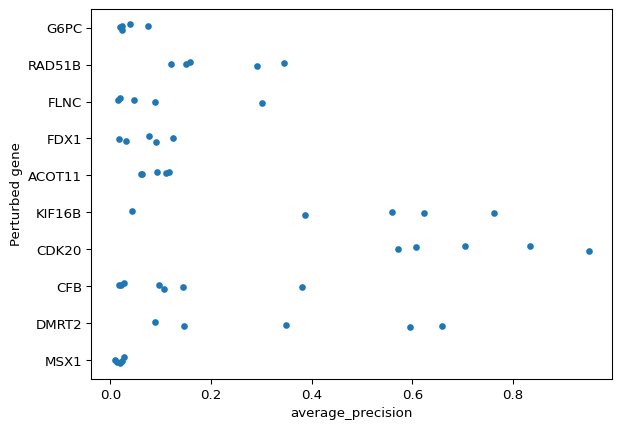

In [6]:
name_mapper = get_mapper(
    subsample, input_column="JCP2022", output_columns="JCP2022,standard_key"
)

to_plot = result.filter(pl.col("pert_type") == "trt").with_columns(
    pl.col("Metadata_JCP2022").replace(name_mapper).alias("Perturbed gene")
)

# Plotting
sns.stripplot(data=to_plot.to_pandas(), x="average_precision", y="Perturbed gene")

We can see that only some perturbations can be easily retrieved when
compared to negative controls, in this case KIF16B and CDK20. For a
deeper dive into how mean Average Precision (mAP) works, you can explore
[this](https://github.com/alxndrkalinin/copairs/blob/v0.4.2/examples/demo.ipynb)
notebook.